# Homework 2 solutions

## 1. Integration error

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate

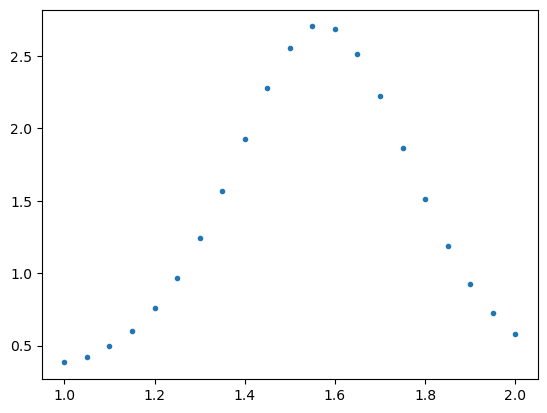

I, err= 1.4829743447687127 5.408170986441626e-14


In [2]:
# First, generate the file 'hw2_data.txt' -- this is given to you in the homework,
# but here is how I generated it
# Also I calculate the 'true' value of the integral

x = np.linspace(1.0,2.0,21)
func = lambda x: np.exp(np.sin(5*x))
f = func(x)
plt.plot(x,f,".")
plt.show()

np.savetxt('hw2_data.txt', np.column_stack((x,f)))

# Calculate the integral
I0, err0 = scipy.integrate.quad(func,1,2)
print("I, err=", I0,err0)

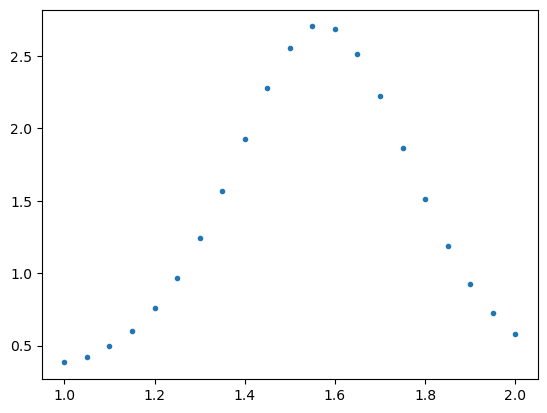

In [3]:
# Read in the data
xp, fp = np.loadtxt('hw2_data.txt', unpack=True)

plt.plot(xp,fp,'.')
plt.show()

In [4]:
# Now carry out two different integrations and compare to estimate the error

# Trapezoid
I1 = scipy.integrate.trapezoid(fp,xp)
I2 = scipy.integrate.trapezoid(fp[::2], xp[::2])
print(I1, I2, (I1-I2)/3, I1-I0)

# Simpson
I3 = scipy.integrate.simpson(fp,xp)
I4 = scipy.integrate.simpson(fp[::2], xp[::2])
print(I3, I4, (I3-I4)/15, I3-I0)

# Ratio
print("Ratio of errors = ",((I1-I2)/3) / ((I3-I4)/15))
N=21
print("N^2 = 21^2 = ", N*N)
print("1/N^2 = %g;   1/N^4 = %g" % (1/N**2, 1/N**4))

1.4823547292600145 1.4805073649598721 0.0006157881000474763 -0.000619615508698157
1.4829705173600622 1.4829048187332472 4.379908454336482e-06 -3.827408650458608e-06
Ratio of errors =  140.59382895041875
N^2 = 21^2 =  441
1/N^2 = 0.00226757;   1/N^4 = 5.14189e-06


We can see that the error estimates are very close to the true values!

## 2. Chemical potential of a Fermi gas

First, rewrite the integral using $x=\epsilon/ k_BT$, $\alpha=\mu/k_BT$ and the definition of $n_Q$:

$${N\over Vn_Q} = {4\over\sqrt{\pi}} \int_0^\infty {x^{1/2} dx\over e^{x-\alpha}+1}$$

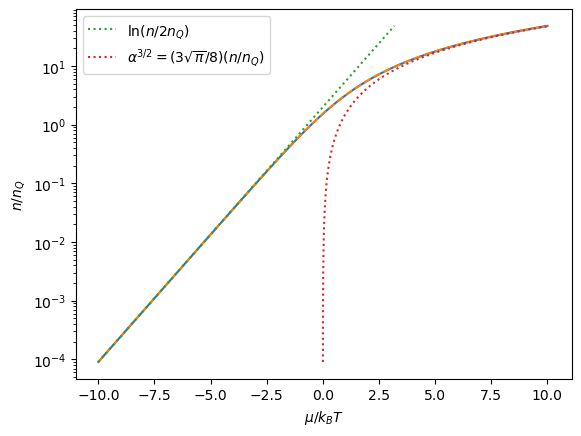

In [5]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

pref = 4.0/np.sqrt(np.pi)
# in the next line we write the Fermi distribution with exp(-x) instead of exp(x-a)
# to avoid overflow errors
func = lambda x, a: pref * x**0.5 *np.exp(-x) / (np.exp(-a)+np.exp(-x))

# Values of a=mu/kT to evaluate the integral
a_vec = np.linspace(-10.0,10.0,100)
n_vec = np.zeros_like(a_vec)

for i, a in enumerate(a_vec):
    n_vec[i], err = scipy.integrate.quad(func,0.0,np.inf,args=(a,))
    
# Now interpolate: use a spline
a_spline = scipy.interpolate.CubicSpline(n_vec,a_vec)
    
# Compute the non-degenerate and degenerate limits
a_nondeg = lambda n: np.log(n/2)
a_deg = lambda n: ((3*np.pi**0.5 /8)*n)**(2/3)

plt.plot(a_vec, n_vec)
plt.plot(a_spline(n_vec), n_vec, "--")
plt.plot(a_nondeg(n_vec), n_vec, ":", label=r'$\ln (n/2n_Q)$')
plt.plot(a_deg(n_vec), n_vec, ":", label=r'$\alpha^{3/2}=(3\sqrt{\pi}/8)(n/n_Q)$')
plt.legend()
plt.ylabel(r'$n/n_Q$')
plt.xlabel(r'$\mu/k_BT$')
plt.yscale('log')
plt.show()

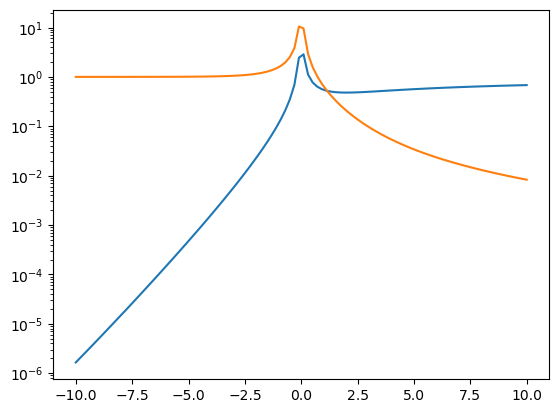

Degenerate limit is valid for n/n_Q>41.18 and mu/kT > 8.9899
Degenerate limit is valid for n/n_Q<0.127874 and mu/kT < -2.72727


In [6]:
# Find where the error crosses 0.01

err_nondeg = np.abs((a_nondeg(n_vec)-a_spline(n_vec))/a_spline(n_vec))
err_deg = np.abs((a_deg(n_vec)-a_spline(n_vec))/a_spline(n_vec))

plt.plot(a_spline(n_vec), err_nondeg)
plt.plot(a_spline(n_vec), err_deg)
plt.yscale('log')
plt.show()

ind = np.where(err_deg>0.01)
print(r'Degenerate limit is valid for n/n_Q>%g and mu/kT > %g'
      % (n_vec[ind[0][-1]], a_spline(n_vec[ind[0][-1]])))

ind = np.where(err_nondeg<0.01)
print(r'Degenerate limit is valid for n/n_Q<%g and mu/kT < %g'
      % (n_vec[ind[0][-1]], a_spline(n_vec[ind[0][-1]])))

## 3. Sampling the Maxwell-Boltzmann distribution

In [7]:
def MaxwellBoltzmann(N, quiet=False):
    # Use a rejection method to draw energies for particles 
    # from a Maxwell-Boltzmann distribution
    # The energies are measured in units of kT
    # NB - we ask for N particles, but may get fewer back depending on the 
    # sampling efficiency
    vmax = 5.0
    nsamples = 5*N
    x = vmax * np.random.rand(nsamples)
    y = np.random.rand(nsamples) * np.exp(-1)
    x_keep = x[y < x**2*np.exp(-x**2)]
    if not quiet:
        print('Acceptance fraction = ', len(x_keep)/nsamples)
    return x_keep[:N]

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time

t0 = time.time()

# First draw a sample of photons from a Maxwell-Boltzmann distribution
T = 1.0
N = int(1e6)
v = MaxwellBoltzmann(N)

print('Time taken = ', time.time()-t0)
print('Number of velocities generated = ', len(v))

Acceptance fraction =  0.2411046
Time taken =  0.3320157527923584
Number of velocities generated =  1000000


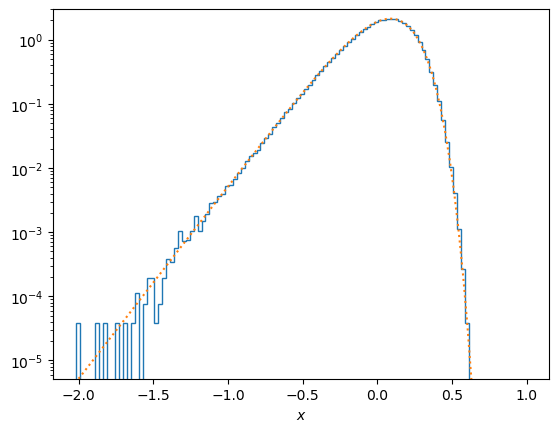

In [9]:
# Compare the distribution of samples with the analytic one

plt.hist(np.log10(v), density=True, bins=100, histtype = 'step')

xvals = 10.0**np.linspace(-2.0,1.0,100)
fMB = (4/np.pi**0.5) * xvals**3 * np.exp(-xvals**2) * np.log(10.0)
plt.plot(np.log10(xvals), fMB, ":")

plt.yscale('log')
plt.ylim((fMB[0], 3))
plt.xlabel(r'$x$')
plt.show()

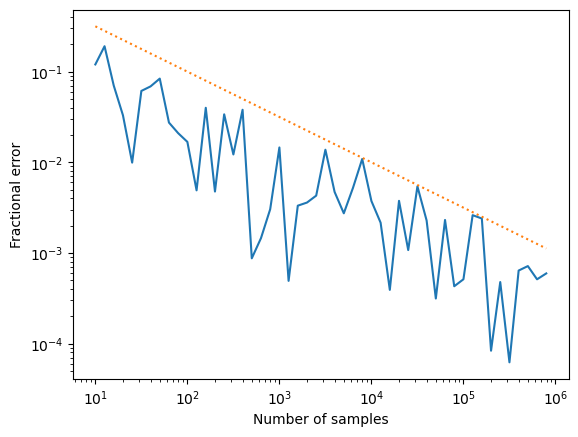

In [10]:
# Now investigate how the error scales with N  (we expect 1/sqrt N)

nums = 10.0**np.arange(1.0,6.0,0.1)

errs = np.zeros_like(nums)

v_analytic = (4.0/np.pi)**0.5

for i, num in enumerate(nums):
    N = int(num)
    v = MaxwellBoltzmann(N, quiet=True)
    v_mean = np.mean(v)
    errs[i] = abs((v_mean-v_analytic)/v_analytic)
    #print('N = ', N, ' Mean velocity =', v_mean, ' Error=', errs[i])
    
plt.loglog(nums,errs)
plt.plot(nums, 1/np.sqrt(nums), ":")
plt.xlabel('Number of samples')
plt.ylabel('Fractional error')
plt.show()